In [5]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

Unrecognized magic `%%capture`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [10]:
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.0-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; Pkg.add("IJulia"); precompile'

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [ ]:
import Pkg
Pkg.add(["HTTP"])
Pkg.add("LOLTools")
Pkg.add("JSON3")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("DataFramesMeta")
Pkg.add("Chain")
Pkg.add("SharedArrays")
Pkg.add("FileIO")

In [ ]:
begin
    #using Revise
    import LOLTools
    import JSON3
    import CSV
  	import HTTP
  	import LOLTools
    using Base.Threads
    using DataFrames
    using DataFramesMeta
    using Chain
    using SharedArrays
    using FileIO
end;

In [2]:
#import data and processing packages
import LOLTools
import JSON3
import CSV
import DataFrames
import DataFramesMeta
import HTTP


"""
Given a type of event and a dataframe of events
Returns a dataframe filtered by the given type
"""
function displayEvents(df::DataFrames.DataFrame,eventType::AbstractString)::DataFrames.DataFrame
    tmp = filter(:type => x -> x==eventType ,df;view=false)
    tmp = tmp[!, all.(! ismissing,eachcol(tmp))]
    #vscodedisplay(tmp)
    return tmp
end

export recKeysPrint,getMatchIds,getEvents,displayEvents,getMetadata,getPlayersData,getPlayersDataAndEvents
export eventsListDfs

function getMetadata(pmd::LOLTools.MatchV5.MatchDto)
    filt = Tuple(
    x for x in fieldnames(typeof(pmd.info))
    if !(x in (:participants,:teams))
    )
    return NamedTuple{filt}(pmd.info)
end

"""
Returns a list of all events of a match given its timelinedata
"""
function getEvents(tmd::LOLTools.MatchV5.MatchTimelineDto)::Base.MethodList
    #iterate over frames
    events_list = Array{Any}(undef)
    for frame in tmd.info.frames
        #get events
        push!(events_list,frame.events...)
    end
    return (
        frameInterval = tmd.info.frameInterval,
        eventsList = events_list
    )
end

function getPlayersData(pmd::LOLTools.MatchV5.MatchDto,tmd::LOLTools.MatchV5.MatchTimelineDto)
    players = Dict()
    for i in 1:10
        participant_frames = []
        for frame in tmd.info.frames
            push!(
                participant_frames,
                frame.participantFrames[i]
            );
        end
        push!(
            players,
            Symbol(pmd.info.participants[i].summonerName) => (
                timeline = participant_frames,
                postmatch = pmd.info.participants[i]
            )
        );
    end
    nt = (;players...);
    return nt
end

function getPlayersDataAndEvents(pmd::LOLTools.MatchV5.MatchDto,tmd::LOLTools.MatchV5.MatchTimelineDto)
    events_list = []
    players = Dict()
    for i in 1:10
        participant_frames = []
        for frame in tmd.info.frames
            push!(
                participant_frames,
                frame.participantFrames[i]
            );
            if i == 1
                push!(events_list,frame.events...)
            end
        end
        push!(
            players,
            Symbol(pmd.info.participants[i].summonerName) => (
                timeline = participant_frames,
                postmatch = pmd.info.participants[i]
            )
        );
    end
    nt = (;players...);
    eventsout = (
        frameInterval = tmd.info.frameInterval,
        eventsList = events_list
    )
    return nt,eventsout
end

function recKeysPrint(x;keysSet=Set(),level=0,symmetric = true, echo = true ,f= (k,v)->k, visitAll = false)
    if isa(x,NamedTuple)
        for key in keys(x)
            if !(key in keysSet) | visitAll == true
                if echo == true
                    println("   "^level * f(String(key),x[key]))
                else
                    if ! isa(x[key],NamedTuple)
                        f(String(key),x[key]);
                    end
                end
                push!(keysSet,key);
            end
            recKeysPrint(x[Symbol(key)],keysSet = keysSet,level = level+1,symmetric = symmetric, f= f,echo = echo, visitAll = visitAll)
        end
    end
    if isa(x,Vector) | isa(x,Tuple)
        if symmetric == true
            if echo == true
                println("   "^(level+1) * "[Array of $(size(x)[1]) elements]")
            end
            recKeysPrint(x[1],keysSet = keysSet,level = level+1,symmetric = symmetric, f= f,echo = echo, visitAll = visitAll)
        else
            for el in x
                recKeysPrint(el,keysSet = keysSet,level = level+1,symmetric = symmetric, f= f,echo = echo)
            end
        end
    end
end

"""
    queue
    type
    etc
"""
function getMatchIds(puuid :: String,api_key=api_key::String,region=region::String;start::Int=0,count::Int=20, kwargs...)
    header=Dict(
        "User-Agent" => "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36",
        "Accept-Language" => "it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7",
        "Accept-Charset" => "application/x-www-form-urlencoded; charset=UTF-8",
        "Origin" => "https://developer.riotgames.com",
        "X-Riot-Token" => "$(api_key)");
    args = []
    for arg in kwargs
        k,v = arg
        if k != nothing
            push!(args,"&$k=$v")
        end
    end
    rep = HTTP.get("https://$(region).api.riotgames.com/lol/match/v5/matches/by-puuid/$(puuid)/ids?start=$(start)&count=$(count)"*"$(args...)",headers=header);
    return collect(m.match for m in eachmatch(Regex(raw"(\w+_\w+)"),String(rep.body)))
end

function eventsListToDf(eventslist::Vector{Any})::DataFrames.DataFrame
    #calculate columns
    eventkeys = Set()
    for event in eventslist
        push!(eventkeys,keys(event)...)
    end
    nt = (; zip(eventkeys, Any[] for i in 1:length(eventkeys))...)

    #init
    eventsdf = DataFrame(nt)
    #push events
    for ev in eventslist
        push!(eventsdf,ev;cols=:subset)
    end
    return eventsdf
end

eventsListToDf (generic function with 1 method)

In [37]:
Pkg.add(["Query","Statistics","VegaLite"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [3]:
begin
    using Query
    import Statistics
    using VegaLite
end

In [7]:
begin
    matchId_debug = "EUW1_5572542603"
    region_debug = "EUROPE"
    token_key_debug = "RGAPI-75f3a1bc-c268-4792-815f-be68a0efe443"

    api_key_debug = LOLTools.get(ENV,"RIOT_TOKEN",token_key_debug)
end;

In [8]:
begin
    #define summoner names
    summonerNames = Vector{String}(undef,0)
    summonerNames = @chain begin
        split(
            "Gh0stRider66,Yotagarasu,Drewku,PannaCòtta,SMZ KiMiMARO"
        ,",")
        map(strip,_)
        map(String,_)
    end
    println("Giocatori \n" * join(summonerNames,"\n"))
    #find puuids
    println("Querying puuids...")
    puuids = Array{String}(undef,0)
    for name in summonerNames
        push!(puuids,LOLTools.SummonerV4.summoner_by_name(api_key_debug,"euw1",name).puuid)
        sleep(0.1)
    end
    #useful dictionary
    id2name = Dict(zip(puuids,summonerNames))

    #get matchIds for every player
    println("Getting the match ids...")
    matchIds = Set{String}()
    for pid in puuids
        mids_pp = getMatchIds(
            pid,
            api_key_debug,
            region_debug,
            count=2,
            queue = 440, #flex
            startTime = 1636930800
        )
        global matchIds = union!(matchIds,mids_pp)
        sleep(0.1)
    end
    matchIds = map(string,collect(matchIds))
    
    #print somestuff
    @show first(sort(matchIds),3)
    @show last(sort(matchIds),3);
    @show length(matchIds)
    id2name
end

Giocatori 
Gh0stRider66
Yotagarasu
Drewku
PannaCòtta
SMZ KiMiMARO
Querying puuids...
Getting the match ids...
first(sort(matchIds), 3) = ["EUW1_5586624572", "EUW1_5586687650", "EUW1_5588216256"]
last(sort(matchIds), 3) = ["EUW1_5591432221", "EUW1_5592967868", "EUW1_5594964317"]
length(matchIds) = 7


Dict{String, String} with 5 entries:
  "gDMCLpRtS_H8NjGWYoagMZk3iiGc75B-D_iLsjMgey0MnCR7q05dCrr8m5… => "Gh0stRider66"
  "bVIPg3MIarmna55cOlJJMRmqvmDoJ0MWBffHnCDmKVU7NHw0KubYqDKfhk… => "Yotagarasu"
  "qsD80lzTzRtaGhwfYTDg0N70Ly2hwYimkextx_nNV6diDhAHLrg431R_f9… => "PannaCòtta"
  "8sHY7wsOOwePbECkUfwsLezHEOWswxkmwqKC6oh6VHAm-lLWPavBynEhpp… => "SMZ KiMiMARO"
  "YtCni9Okea_CDv9mRCbqjBSH4XUbfZ0mbj8KeH_jNA-M9Z1hvwTI5Zp-_4… => "Drewku"

In [9]:
function fetchDataFromAPI(
    matchIds::Vector{String},
    api_key_debug::String = api_key_debug,
    region_debug::String = region_debug,
)::Vector{NamedTuple}

    #prepare empty matchdata array
    matchDatas = Array{NamedTuple}(undef,length(matchIds))
    println("Downloading data...")
    Threads.@threads :static for (k,mid) in collect(enumerate(matchIds))
        mid = String(mid)
        #download data
        postmatchData = LOLTools.MatchV5.match_by_match_id(api_key_debug,region_debug,mid);
        timelineData = LOLTools.MatchV5.match_timeline_by_match_id(api_key_debug,region_debug,mid);
        #get timelines and events
        players,events = getPlayersDataAndEvents(postmatchData,timelineData)
        #get myTeamId
        myTeamId = @from p in DataFrame(players) begin
            @where p.postmatch.puuid in puuids
            @select {p.postmatch.teamId}
            @collect DataFrame
        end
        myTeamId = @chain myTeamId begin
            groupby([:teamId])
            combine(nrow)
        end
        myTeamId = myTeamId[argmax(myTeamId.nrow...),:teamId]
        #struct the data
        matchInfo = (
            puuids = Dict(
                zip(
                postmatchData.metadata.participants,
                [postmatchData.info.participants[i].summonerName for i in 1:10]
                )
            ),
            metadata = getMetadata(postmatchData),
            teams = postmatchData.info.teams,
            #players = getPlayersData(postmatchData,timelineData),
            #events = getEvents(timelineData)
            players = players,
            eventsContainer = events,
            myTeamId = myTeamId,
            matchId = mid
        );
        #push matchInfo
        matchDatas[k]=matchInfo
        println("Added match $(mid)")
    end
    println("Done")
    return matchDatas
end;

In [10]:
begin
    DataFrame()
    fetchDataFromAPI(matchIds[1:2])
    matchDatas = fetchDataFromAPI(matchIds)
end;

Added match EUW1_5586687650
Added match EUW1_5594964317
Done
Added match EUW1_5586687650
Added match EUW1_5594964317
Added match EUW1_5592967868
Added match EUW1_5588216256
Added match EUW1_5591432221
Added match EUW1_5588375357
Added match EUW1_5586624572
Done


In [11]:
t_megaObjDf = @spawn begin
    megaObjDf = begin
        println("Creating a dataframe about objectives...")
        megaObjDf = DataFrame()
        for c in matchDatas
            out = DataFrame()
            for t in c.teams
                a = DataFrame(t.objectives)
                b = DataFrame(objName = collect(keys(t.objectives)),
                    teamId = t.teamId,
                    win = t.win,
                    myTeam = c.myTeamId,
                    matchId = c.matchId
                    )
                append!(out,[a b])
            end
            append!(megaObjDf,out)
        end
        megaObjDf
    end;
end

Creating a dataframe about objectives...


Task (done) @0x00007f63563ffde0

In [12]:
t_megaBansDf = @spawn begin
    megaBansDf = begin
        println("Creating a dataframe of bans...")
        megaBansDf = DataFrame()
        for c in matchDatas
            out = DataFrame()
            for t in c.teams
                a = DataFrame(t.bans)
                b = DataFrame(
                    teamId = fill(t.teamId,length(t.bans)),
                    win = t.win,
                    myTeamId = c.myTeamId,
                    matchId = c.matchId
                    )
                append!(out,[a b])
            end
            append!(megaBansDf,out)
        end
        megaBansDf
    end;
end

Creating a dataframe of bans...


Task (done) @0x00007f635676cfe0

In [45]:
Pkg.add("Downloads")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [13]:
mkpath("./assets/")

"./assets"

In [14]:
download("http://ddragon.leagueoflegends.com/cdn/11.23.1/data/en_US/runesReforged.json", "./assets/runesReforged.json")

"./assets/runesReforged.json"

In [15]:
t_perksDataBase = @spawn begin

    println("Downloading a database of perks")

    perksDataBase = @chain "./assets/runesReforged.json" begin
        read(String)
        JSON3.read()
        DataFrame()
        @aside x = _
        flatten(:slots)
        map( x-> DataFrame(x.runes) , _[!,:slots])
        reduce(vcat,_)
        vcat(_,x[:,1:4];cols=:union)
    end;
end

Task (done) @0x00007f635676f820

In [77]:
t_megaPostmatchDf = @spawn begin
    megaPostmatchDf = begin
        println("Creating a dataframe of postmatch data...")
        dfooo = DataFrame()
        for m in matchDatas
            name2puuid = Dict(map(reverse,collect(m.puuids))) # fram name to puuid
            playerSymbols = keys(m.players) # player symbols
            playerNames = map(string,playerSymbols) # player names(String)
            dfoo = DataFrame()
            for (i,p) in enumerate(m.players) #indice i player p
                #timeline ; postmatch
    
                #hint recKeysPrint(p.postmatch) or keys(p.postmatch)
                a = push!(DataFrame(),p.postmatch)
    
                b = DataFrame(
                    matchId = m.matchId,
                    myTeamId = m.myTeamId,
                    gameDuration = m.metadata.gameDuration
                )
    
                append!(dfoo,[a b];cols=:union)
    
            end
            append!(dfooo,dfoo)
        end
        select!(dfooo,Not(:perks))
    end;
end

Creating a dataframe of postmatch data...


Task (done) @0x00007f630901eb30

In [17]:
t_megaTimelineDf = @spawn begin
    megaTimelineDf = begin
        println("Creating a dataframe of timeline player stats")
        dfooo = DataFrame()
        for m in matchDatas
            name2puuid = Dict(map(reverse,collect(m.puuids))) # fram name to puuid
            playerSymbols = keys(m.players) # player symbols
            playerNames = map(string,playerSymbols) # player names(String)
            dfoo = DataFrame()
            for (i,p) in enumerate(m.players) #index i player p
                #timeline ; postmatch
    
                #hint recKeysPrint(p.postmatch) or keys(p.postmatch)
                dfo = DataFrame()
                #loop over frames
                for (k,frame) in enumerate(p.timeline) #array
                    
                    #we want to extract championStats,damageStats and position
                    local df = DataFrame()
                    #championStats
                    a = push!(DataFrame(),frame.championStats)
                    b = push!(DataFrame(),frame.damageStats)
                    c = push!(DataFrame(),frame.position)
    
                    KEYS = filter( x -> !(x in [:championStats,:damageStats,:position]) ,keys(frame))
                    
                    d = push!(DataFrame(),
                        NamedTuple{KEYS}(frame)
                    )
                    e = DataFrame(
                        timestamp = m.eventsContainer.frameInterval*(k-1),
                        frameInterval = m.eventsContainer.frameInterval,
                        myTeamId = m.myTeamId,
                        matchId = m.matchId,
                        puuid = collect(keys(m.puuids))[i]
                    )
                    df = [a b c d e]
                    append!(dfo, df) # primary secondary
                end
                append!(dfoo,dfo)
            end
            append!(dfooo,dfoo)
        end
        dfooo
    end;
end

Creating a dataframe of timeline player stats


Task (done) @0x00007f6358c5dcd0

In [18]:
t_megaEventsDf = @spawn begin 
    megaEventsDf = begin
        println("Creating a dataframe of events")
        function f(x)
            y = eventsListToDf(x.eventsContainer.eventsList)
            l = size(y)[1]
            return DataFrame(matchId = fill(x.matchId,l),myTeamId = x.myTeamId)
        end
        tmp = map( x -> [eventsListToDf(x.eventsContainer.eventsList) f(x)], matchDatas)
        vcat(tmp...,cols=:union)
    end;
end;

Creating a dataframe of events


In [19]:
perksDataBase = fetch(t_perksDataBase)

# ╔═╡ 482bcd64-2cff-48b2-a926-3b0d6e2b0807
t_megaPerksDf = @spawn begin
    #perks
    megaPerksDf = begin
        println("Creating a dataframe of perks...")
        dfooo = DataFrame()
        for m in matchDatas
            name2puuid = Dict(map(reverse,collect(m.puuids))) # fram name to puuid
            playerSymbols = keys(m.players) # player symbols
            playerNames = map(string,playerSymbols) # player names(String)
            dfoo = DataFrame()
            for (i,p) in enumerate(m.players) #indice i player p
                #timeline ; postmatch
    
                #hint recKeysPrint(p.postmatch) or keys(p.postmatch)
                dfo = DataFrame()
                #stackPerks is not informative
                for style in p.postmatch.perks.styles #array of 2 elements
                    #description can be dropped
                    #we want selection and style, style is important
                    local df = DataFrame()
                    for s in style.selections #array of tuples
                        @chain DataFrame() begin
                            push!(s) #dataframe of what I want(selection)
                            hcat(# add additional information
                                DataFrame(
                                style=style.style,
                                puuid = name2puuid[playerNames[i]], 
                                matchId = m.matchId
                                )
                            )
                            
                            append!(df,_) #save
                        end
                        # tmp = push!(DataFrame(),s)
                        # tmp = hcat(tmp, DataFrame(style=style.style, puuid = name2puuid[playerNames[i]], matchId = m.matchId))
                        # append!(df,tmp)
                    end
                    append!(dfo, df) # primary secondary
                end
                append!(dfoo,dfo)
            end
            append!(dfooo,dfoo)
        end
        dfooo
    end;
end

Creating a dataframe of perks...


Task (done) @0x00007f6359799fb0

In [20]:
eventTypes = unique(fetch(t_megaEventsDf),"type")[!,:type]

17-element Vector{Any}:
 "PAUSE_END"
 "ITEM_PURCHASED"
 "SKILL_LEVEL_UP"
 "LEVEL_UP"
 "ITEM_DESTROYED"
 "WARD_PLACED"
 "WARD_KILL"
 "CHAMPION_KILL"
 "CHAMPION_SPECIAL_KILL"
 "TURRET_PLATE_DESTROYED"
 "ELITE_MONSTER_KILL"
 "ITEM_UNDO"
 "BUILDING_KILL"
 "ITEM_SOLD"
 "DRAGON_SOUL_GIVEN"
 "GAME_END"
 "CHAMPION_TRANSFORM"

In [21]:
download("https://raw.communitydragon.org/json/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-icons/", "./iconsList.json")

"./iconsList.json"

In [22]:
iconsList = JSON3.read(read("./iconsList.json"))
mkpath("./assets/icons/")
for item in iconsList
  download("https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-icons/$(item.name)","./assets/icons/$(item.name)")
end

In [23]:
megaPerksDf = fetch(t_megaPerksDf)

begin
    fromPerkIdToPerkName(database,id) = filter( (x-> x.id==(id)), database)[1,:key] 
    fromPerkIdToPerkIcon(database,id) = filter( (x-> x.id==(id)), database)[1,:icon] 
    megaPerksDf[!,:icon] = map(x-> "http://ddragon.leagueoflegends.com/cdn/img/" * fromPerkIdToPerkIcon(perksDataBase,x),megaPerksDf[:,:perk]) 
    megaPerksDf[!,:perk] = map(x->fromPerkIdToPerkName(perksDataBase,x),megaPerksDf[:,:perk]) 
    megaPerksDf[!,:style] = map(x->fromPerkIdToPerkName(perksDataBase,x),megaPerksDf[:,:style]) 
end;

In [78]:
begin
    macro name(x)
        string(x)
    end

    hostTeam = "HOF"
    teamName = "team01122021"

    path = "./teams/$hostTeam/$teamName/"
    if ! isdir(path)
        mkpath(path)
    end
    
    megaTimelineDf = fetch(t_megaTimelineDf)
    CSV.write(path * "megaTimelineDf.csv",megaTimelineDf)
    megaBansDf = fetch(t_megaBansDf)
    CSV.write(path * "megaBansDf.csv",megaBansDf)
    megaEventsDf = fetch(t_megaEventsDf)
    CSV.write(path * "megaEventsDf.csv",megaEventsDf)
    megaObjDf = fetch(t_megaObjDf)
    CSV.write(path * "megaObjDf.csv",megaObjDf)
    megaPostmatchDf = fetch(t_megaPostmatchDf)
    CSV.write(path * "megaPostmatchDf.csv",megaPostmatchDf)
    #megaPerksDf = fetch(t_megaPerksDf)
    CSV.write(path * "megaPerksDf.csv",megaPerksDf)
    #display(first(megaPostmatchDf,3))
    #display(first(megaTimelineDf,3))
    #display(first(megaObjDf,3))
    #display(first(megaPerksDf,3))
    #display(first(megaBansDf,3))
end

"./teams/HOF/team01122021/megaPerksDf.csv"

In [34]:
# Pkg.add("Images")

In [35]:
# Pkg.add("ImageView")

In [36]:
using Images

img = load("./assets/icons/-1.png")
function handwrittenresize(img)
    tmp = Array{Images.RGBA{Images.N0f8}}(undef,0)
    if size(img) == (360,360)
      for r in 1:size(img)[1]
          for c in 1:size(img)[2]
              if r%3==0 && c%3==0
                  push!(tmp,img[c,r])
              end
          end
      end
    else
      return img
    end

    return reshape(tmp,(120,120))
end
resized = handwrittenresize(img)
FileIO.save("./assets/icons/-1.png",resized)

0

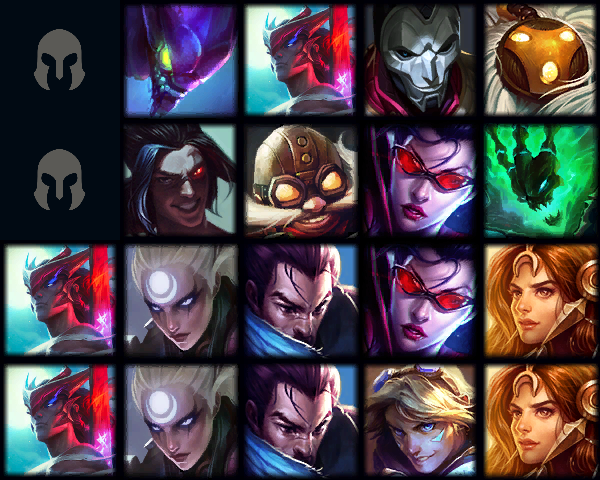

In [37]:
comps_img = begin
    #using ImageView

    grps = @chain megaPostmatchDf begin
        transform(:puuid => ByRow(x-> x in puuids) => :analyze) #preprocess
        sort([:analyze,:win];rev=true,view=true,alg=Base.Sort.InsertionSort) #fast sort
        groupby([:matchId],sort=false)
        #min team members
        filter( x-> (sum(x[1:5,:analyze])>=4), _)
        DataFrame #HERE WE CAN FILTER CHAMP FREQ(TO BE IMPLEMENTED)
        #order
        sort([:teamPosition])
        #subset(:puuid => ByRow(x->x in puuids)) DEPRECATED
        #get rid of fill players
        subset([:myTeamId,:teamId] => ByRow((x,y) -> (x==y)))
        #clean championIds
        transform([:championId,:puuid] => ByRow((x,p)-> ((p in puuids) ? x : -1)) => :championId)
        groupby(:matchId)
        #vscodedisplay
    end

    #vscodedisplay(grps[keys(grps)[1]][!,[:teamPosition,:participantId]])
    #icons path
    iconspath = "./assets/icons/"
    cids = []

    for k in keys(grps)
        push!(cids,collect(grps[k].championId))
    end
    cids
    # for (i,x) in enumerate(cids)
    #     cids[i] = map(v -> iconspath * string(v) * ".png",x)
    # end
    for (i,x) in enumerate(cids)
        cids[i] = DataFrame(permutedims(x),:auto)
    end
    cids = reduce(vcat,cids)
    transform!(cids, :x1 => :x4, :x4=>:x1)
    function cluster(df::DataFrame,indices::Array{String})
        idx = 0
        cm = 0
        out = ""
        if length(indices) == 1
            return indices[1]
        end
        for (i,index) in enumerate(indices)
            m = max(combine(groupby(df,index),nrow)[!,:nrow]...)
            if m > cm
                idx = i
                cm = m
                out = index
            end

        end
        res = cluster(df,deleteat!(indices,idx))
        return [out; res]
    end
    sort!(cids,cluster(cids,names(cids)))
    #= imgs = similar(cids)
    for (i,cid) in enumerate(cids)
        imgs[i] = hcat(map(x->load(x),cid)...)
    end
    imgs = vcat(imgs...) =#
    imgs = []
    for row in eachrow(load.(iconspath .* string.(cids) .* ".png"))
        push!(imgs,hcat(row...))
    end
    vcat(imgs...)   
end

In [79]:
print((data[5][!,:gameDuration]))

LoadError: ArgumentError: column name :gameDuration not found in the data frame

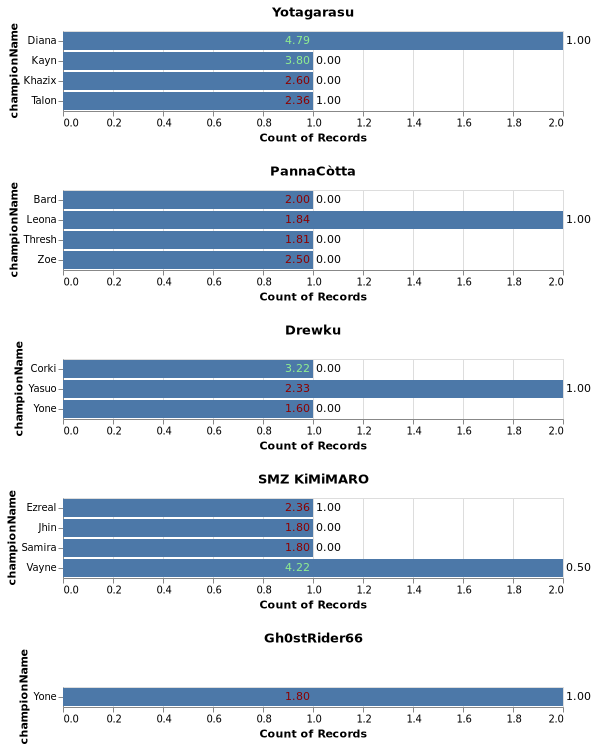

In [100]:
begin
    #PARAMS
    minCount = min(
        3 ,  min(transform(groupby(filter(x->x.puuid in puuids , megaPostmatchDf[!,[:puuid,:championName]]),[:puuid,:championName]),nrow => :count)[!,:count]...)

    )
    #END


    megaPostmatchDf[!,:kda] = (megaPostmatchDf[!,:kills] .+ megaPostmatchDf[!,:assists])./megaPostmatchDf[!,:deaths];
    data = @chain megaPostmatchDf begin 
        filter( x-> x.puuid in puuids, _)
        groupby([:puuid,:championName])
        transform(nrow => :count)
        filter(:count => x-> x>=(minCount),_)
        transform(:gameDuration => x->x/60, renamecols = false)
        groupby(:puuid)
        collect
        
    end;
    a = []
    resize!(a,5)
    for i in 1:5
        a[i] = data[i] |>
        @vlplot(
            width=500,
            title = id2name[data[i].puuid[1]],
            y = {field = :championName},
            x = {field = :championName, aggregate = "count"},
            tooltip = [
                {
                field = :kills, type = "quantitative", aggregate = "mean"
                },
                {
                field = :deaths, type = "quantitative", aggregate = "mean"
                },
                {
                field = :assists, type = "quantitative", aggregate = "mean"
                },
                {
                field = :gameDuration, type = "quantitative", aggregate = "mean"
                },
                {
                field = :turretTakedowns, type = "quantitative", aggregate = "mean"
                },
                {
                field = :totalMinionsKilled, type = "quantitative", aggregate = "mean"
                },
                {
                field = :neutralMinionsKilled, type = "quantitative", aggregate = "mean"
                },
                {
                field = :visionScore, type = "quantitative", aggregate = "mean"
                },
                {
                field = :firstTowerKill, type = "quantitative", aggregate = "mean"
                },
                {
                field = :individualPosition, type = "nominal", aggregate = "max"
                },
                {
                field = "count", type = "quantitative"
                }
            ],
            layer = [{
                mark={
                    type=:bar
                }
                },{
                mark = {type = :text,
                        align = "left",
                        baseline = "middle",
                        dx = 3,
                        },
                encoding = {
                    text = {field = :win, aggregate = "mean", type="quantitative",format = ".2f"},
                }
                },{
                
                transform = [
                    {
                    aggregate = [{op = "mean",field = "kda", as = "kda"}],
                    groupby = ["championName"]
                }
                ],
                mark = {type = :text,
                        align = "right",
                        baseline = "middle",
                        dx = -3,
                        tooltip = "KDA"
                        },
                encoding = {
                    text = {field = :kda, type="quantitative",format = ".2f"},
                    color={
                        
                        condition = {
                            test = "datum['kda'] > 3.0",
                            value = "lightgreen"
                        }
                        ,
                        value="darkred",
                    }
                    
                },
                
            }]

        )
    end
    pool = reduce(vcat,a) 
    save(path*"pool.svg",pool)
    pool
end

In [82]:
comps_img |> save(path*"comps.png");

In [83]:
playersTL = @chain megaTimelineDf begin
	subset(:puuid => ByRow(x-> x in puuids))
	transform([:puuid] => ByRow(x->id2name[x]), renamecols = false)
	transform( :timestamp => x->x/60/1000, renamecols = false)
end

,abilityHaste,abilityPower,armor,armorPen,armorPenPercent,attackDamage,attackSpeed
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,0,31,0,0,25,100
2,0,9,37,0,0,57,128
3,0,9,39,0,0,59,159
4,0,9,41,0,0,61,136
5,0,9,44,0,0,63,140
6,0,9,44,0,0,63,166
7,0,9,46,0,0,66,171
8,0,9,46,0,0,66,174
9,0,9,49,0,0,68,227


In [127]:
asd = @vlplot(
  data = playersTL[!,[:timestamp,:puuid,:matchId,
	:totalGold,
]],
    height = 300,
    width = 500,
	params = [
		{
		name = "selTimestamp",
        value = 2,
		bind = {
			input = "range", min= 1, max= 15, step= 1
			}
		}
	],
    selection = {
        selectedMatches = {
            type = "single",
            fields = [:matchId]
        }
    },
	transform = [
		{
		filter = {field = :timestamp, equal = {expr = "selTimestamp"}}
		},
	],
	mark = {
		type = :circle,
        size = 200
	},
	encoding = {
		x = {
            field = :totalGold,
            scale = {domain = [500,6000]}
        },
		y = {field = :puuid, type = "nominal"},
        color = {
            field = :matchId,
            condition = {
                selection = {not = "selectedMatches"},
                value = "grey",
                },
        },
	}
) 

@vlplot(
    data={
        values=...
    },
    height=400,
    width=600,
    params=[
        {
            name="selTimestamp",
            value=1,
            bind={
                input="range",
                min=1,
                max=15,
                step=1
            }
        },
        {
            name="selectedMatches",
            select={
                type="interval"
            }
        }
    ],
    transform=[
        {
            filter={
                field="timestamp",
                equal={
                    expr="selTimestamp"
                }
            }
        }
    ],
    mark={
        type="circle",
        size=200
    },
    encoding={
        x={
            field="totalGold",
            scale={
                domain=[
                    500,
                    6000
                ]
            }
        },
        y={
            field="puuid",
            type="nominal"
        },
        color={
            condition={
     

TypeError: Cannot read property 'length' of undefined
    at splitAccessPath (/srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lite.js:40:17)
    at flatAccessWithDatum (/srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lite.js:1008:43)
    at vgField (/srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lite.js:4260:14)
    at fieldFilterExpression (/srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lite.js:2908:50)
    at /srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lite.js:14042:16
    at logicalExpr (/srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lite.js:960:14)
    at expression (/srv/julia/pkg/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-lite/build/vega-lit

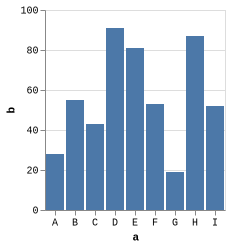

In [232]:
vl"""{
  "params": [
    { "name": "cornerRadius", "value": 0,
      "bind": {"input": "range", "min": 0, "max": 50, "step": 1} }
  ],
  "data": {
    "values": [
      {"a": "A", "b": 28}, {"a": "B", "b": 55}, {"a": "C", "b": 43},
      {"a": "D", "b": 91}, {"a": "E", "b": 81}, {"a": "F", "b": 53},
      {"a": "G", "b": 19}, {"a": "H", "b": 87}, {"a": "I", "b": 52}
    ]
  },
  "mark": {
    "type": "bar",
    "cornerRadius": {"expr": "cornerRadius"}
  },
  "encoding": {
    "x": {"field": "a", "type": "nominal", "axis": {"labelAngle": 0}},
    "y": {"field": "b", "type": "quantitative"}
  }
}"""